## Monge Bregman Occam estimator (arthur.sabre@ensae.fr)

In this tutorial, we will be using OTT to implement the Monge Bregman Occam estimator (https://proceedings.mlr.press/v202/cuturi23a.html) and see how good it is on an application. For a quick reminder, the Monge Problem is defined as follows : consider a translation invariant cost $c(x, y) := h(x - y)$, with $h : \mathbb{R}^d \rightarrow \mathbb{R}$. The Monge problem consists of finding, among all maps $T : \mathbb{R}^d \rightarrow \mathbb{R}^d$ that push-forward a measure $\mu \in \mathcal{P}(\mathbb{R}^d)$ onto $\nu \in \mathcal{P}(\mathbb{R}^d)$, the map $T^\star$ which minimizes


$$T^\star := \text{arg} \inf_{T \sharp \mu = \nu} \int_{\mathbb{R}^d} h(x - T(x)) \, d\mu $$ 

The goal of the Monge Bregman Occam estimator is obviously to estimate $T^\star$, but mainly to obtain a feature-sparse entropic map $T_{h,\epsilon}$, meaning that when we have a high-dimension data $x$, $T_{h,\epsilon}$ only consideers a reduced number of features of $x$, so that the displacement vector : $$\Delta(x) := T_{h,\epsilon}(x) - x$$ is sparse.

## Setup of the context

We will consider translations invariant costs, $c(x, y) = h(x - y)$, where $h$ is such that $h(z) := \frac{1}{2} \|z\|^2 + \tau(z)$ and $\tau : \mathbb{R^d} \rightarrow \mathbb{R}$ is a function whose proximal operator is well-defined (we say that $h$ is of elastic-type). The elastic-type costs considereed subsume, without loss of generality, all strongly-convex translation invariant costs with convex $\tau$.

In this context, Proposition (4.1) of the paper shows that we can rewrite $T_{h,\epsilon}$ using the proximal operator of $\tau$ : $T_{h,\epsilon}(x) = x - \text{prox}_{\tau} \left( x - \sum_{j=1}^{m} p^j(x) \left(y^j - \nabla \tau (x - y^j) \right) \right)$

Based on this Proposition, OTT-JAX allows us to evaluate $T_{h,\epsilon}$ for single points, so that we can use two metrics to observe the quality of the estimation : NMSE (Normalized Mean Squared Error) and Support error.

### Make sure to run these cells if you want to :
- Install JAX and OTT-JAX (first cell)
- run the code on GPU (second cell, useful to run the experimentations on your own side).

In [2]:
# pip install jax ott-jax

In [3]:
# pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

## Let's import the needed libraries

In [4]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from ott.geometry.costs import SqEuclidean, ElasticL1, ElasticL2, ElasticSTVS, ElasticSqKOverlap
from ott.geometry import pointcloud
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem

In this notebook, we will consideer synthetic data. The reasoning is the same as the one done in the paper (Section 5.Experiments) to generate it.

## Constant sparsity-pattern

Let's reproduce the Synthetic experiment about constant sparsity-pattern. In this case, we measure the ability of the method to recover a sparse transport map. Here $\mu = U[0,1]^d$. For an integer $s \leq d$, we set $\nu = T^\star_s \sharp \mu$. In such a context, $T^\star_s(x) = [\exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d]$: it only changes the first $s$ coordinates of the vector, and corresponds to a sparse displacement when $s \ll d$. We consider $n = 1,000$ i.i.d. samples  $x^i$ from $\mu$, and $y^i$ from $\nu$ independently obtained by first generating new $\tilde{x}^i$ samples and then pushing them: $y^i := T^\star_s(\tilde{x}^i))$.

To estimate the quality of the estimation, we will use two metrics :

The NMSE (Normalized Mean Squared Error): $\displaystyle \frac{1}{nd}\sum_{i=1}^{n} \| T^\star_s(x^i) - T_{h,\epsilon}(x^i) \|_2^2$

The Support Error : For a sample $x$, $\displaystyle \frac{{\sum_{i=s+1}^{d} \Delta^2_i}}{{\sum_{i=1}^{d} \Delta^2_i}}$, with $\Delta(x) := T_{h,\epsilon}(x) - x$ the displacement vector. We compute the support error and keep the average support error over all the samples $x^i$.

The smaller the two quantities, the more qualitative the estimator. The support error is between 0 and 1 and cancels if and only if the displacement happens only on the correct coordinates.

## Using OTT-JAX to compute $T_{h,\epsilon}$ on each sample.

Below is an example of how we can take advantage of OTT-JAX to compute $T_{h,\epsilon}$ efficiently for any point(s) $x$ (OTT-JAX allows us to compute the transport map for $n$ samples).

In [25]:
# Define parameters
d = 20 # Dimension
n = 1000 # Number of samples
s = 5 # Number of displaced coordinates

# Generate samples
rng = jax.random.PRNGKey(0)
rng_tilde = jax.random.PRNGKey(1)
x = jax.random.uniform(rng, (n, d))
x_tilde = jax.random.uniform(rng_tilde, (n, d))
# Define ground truth transport map
def T_star_s(x, s):
    return jnp.concatenate([jnp.exp(x[:s]), x[s:]])

# Generate transported samples
y = jax.vmap(T_star_s, in_axes=(0, None))(x_tilde, s)
# Theoricetical transport map
T_star = jax.vmap(T_star_s, in_axes=(0, None))(x, s)

# Define regularized translation invariant cost
# cost = ElasticL1(scaling_reg=10)
# cost = ElasticSTVS(scaling_reg=10)
cost = SqEuclidean()
# cost = ElasticSqKOverlap(k=7, scaling_reg=10)

# Define geometry of the problem using PointCloud
geom = pointcloud.PointCloud(x, y, cost_fn=cost)

# Define the OT Problem in order to solve it using Sinkhorn solver.
problem = linear_problem.LinearProblem(geom)

# Call the Sinkhorn solver.
solver = sinkhorn.Sinkhorn()

# Run Sinkhorn algorithm to compute dual potentials. It gives us a SinkhornOutput object
dual_potentials = solver(problem) # call de la classe Sinkhorn, renvoie un SinkhornOutput

# The SinkhornOutput object is then converted to a DualPotentials object using to_dual_potentials()
entropic_map = dual_potentials.to_dual_potentials()
entropic_map.cost_fn = cost

# Now, we can compute for each point the entropic map T_h_epsilon and the displacement vector.
T_h_eps = entropic_map.transport(x)
displacement_vector = T_h_eps - x

# We now compute our metrics : NMSE and support error
nmse = jnp.mean(jnp.sum((T_star - T_h_eps)**2, axis=1) / d)
support_error = jnp.mean(jnp.sum(displacement_vector[:, s+1:]**2, axis=1) / jnp.sum(jnp.sum(displacement_vector**2, axis=1)))

# Print results
print(f"NMSE: {nmse}")
print(f"Support error: {support_error}")

NMSE: 0.05516031011939049
Support error: 7.74411455495283e-05


Let's create functions to compute both metrics.

In [6]:
# We define our parameters
gammas = jnp.logspace(jnp.log10(7*10**-2), jnp.log10(20), num=100)
s = 5
dimensions = [8, 20, 100]
n = 1000

# We create several dictionaries to store metrics and data efficiently.

SUPPORT_ERROR = {}
NMSE = {}
costs = ["SqEuclidean", "ElasticL1", "ElasticSTVS", "ElasticSqKOverlap (k=5)", "ElasticSqKOverlap (k=7)"]
for cost in costs:
    SUPPORT_ERROR[cost] = {}
    NMSE[cost]= {}
    for i, dimension in enumerate(dimensions):
        SUPPORT_ERROR[cost][dimension] = {}
        NMSE[cost][dimension] = {}
        SUPPORT_ERROR[cost][dimension][s] = []
        NMSE[cost][dimension][s] = []
NMSE, SUPPORT_ERROR

x_diction = {}
y_diction = {}
T_star = {}
for dimension in dimensions:
    x_diction[dimension] = jax.random.uniform(rng, (n, dimension))
    x_tilde = jax.random.uniform(rng_tilde, (n, dimension))
    y_diction[dimension] = jax.vmap(T_star_s, in_axes=(0, None))(x_tilde, s)
    T_star[dimension] = jax.vmap(T_star_s, in_axes=(0, None))(x_diction[dimension], s)

Here, we compute everything we want (Both metrics for each cost, dimension) in a single cell to reproduce the experimentation made on Figure 5.

In [7]:
for i, elastic_cost in enumerate([SqEuclidean, ElasticL1, ElasticSTVS, ElasticSqKOverlap, ElasticSqKOverlap]):
    for j, dimension in enumerate(dimensions):
        x = x_diction[dimension]
        y = y_diction[dimension]
        T_star_x = T_star[dimension]
        # Compute Support Error and NMSE for each gamma and store the values in the associated dictionaries.
        if elastic_cost != SqEuclidean:
            for gamma in gammas:
                if elastic_cost == ElasticSqKOverlap:
                    if i == 3:
                        cost = elastic_cost(k=5, scaling_reg=gamma)
                    else:
                        cost = elastic_cost(k=7, scaling_reg=gamma)
                else:
                    cost = elastic_cost(scaling_reg=gamma)

                # Compute NMSE and support error
                T_h_eps = compute_transport(x, y, cost)
                nmse = compute_nmse(T_star_x, T_h_eps)
                support_error = compute_se(x, T_h_eps, s)
                NMSE[costs[i]][dimension][s].append(nmse)
                SUPPORT_ERROR[costs[i]][dimension][s].append(support_error)
        else:
            cost = SqEuclidean()
            # Compute NMSE and support error
            T_h_eps = compute_transport(x, y, cost)
            nmse = compute_nmse(T_star_x, T_h_eps)
            support_error = compute_se(x, T_h_eps, s)
            NMSE[costs[i]][dimension][s] = jnp.array([nmse for _ in range(len(gammas))])
            SUPPORT_ERROR[costs[i]][dimension][s] = jnp.array([support_error for _ in range(len(gammas))])

Now, we check the results by plotting our metrics.

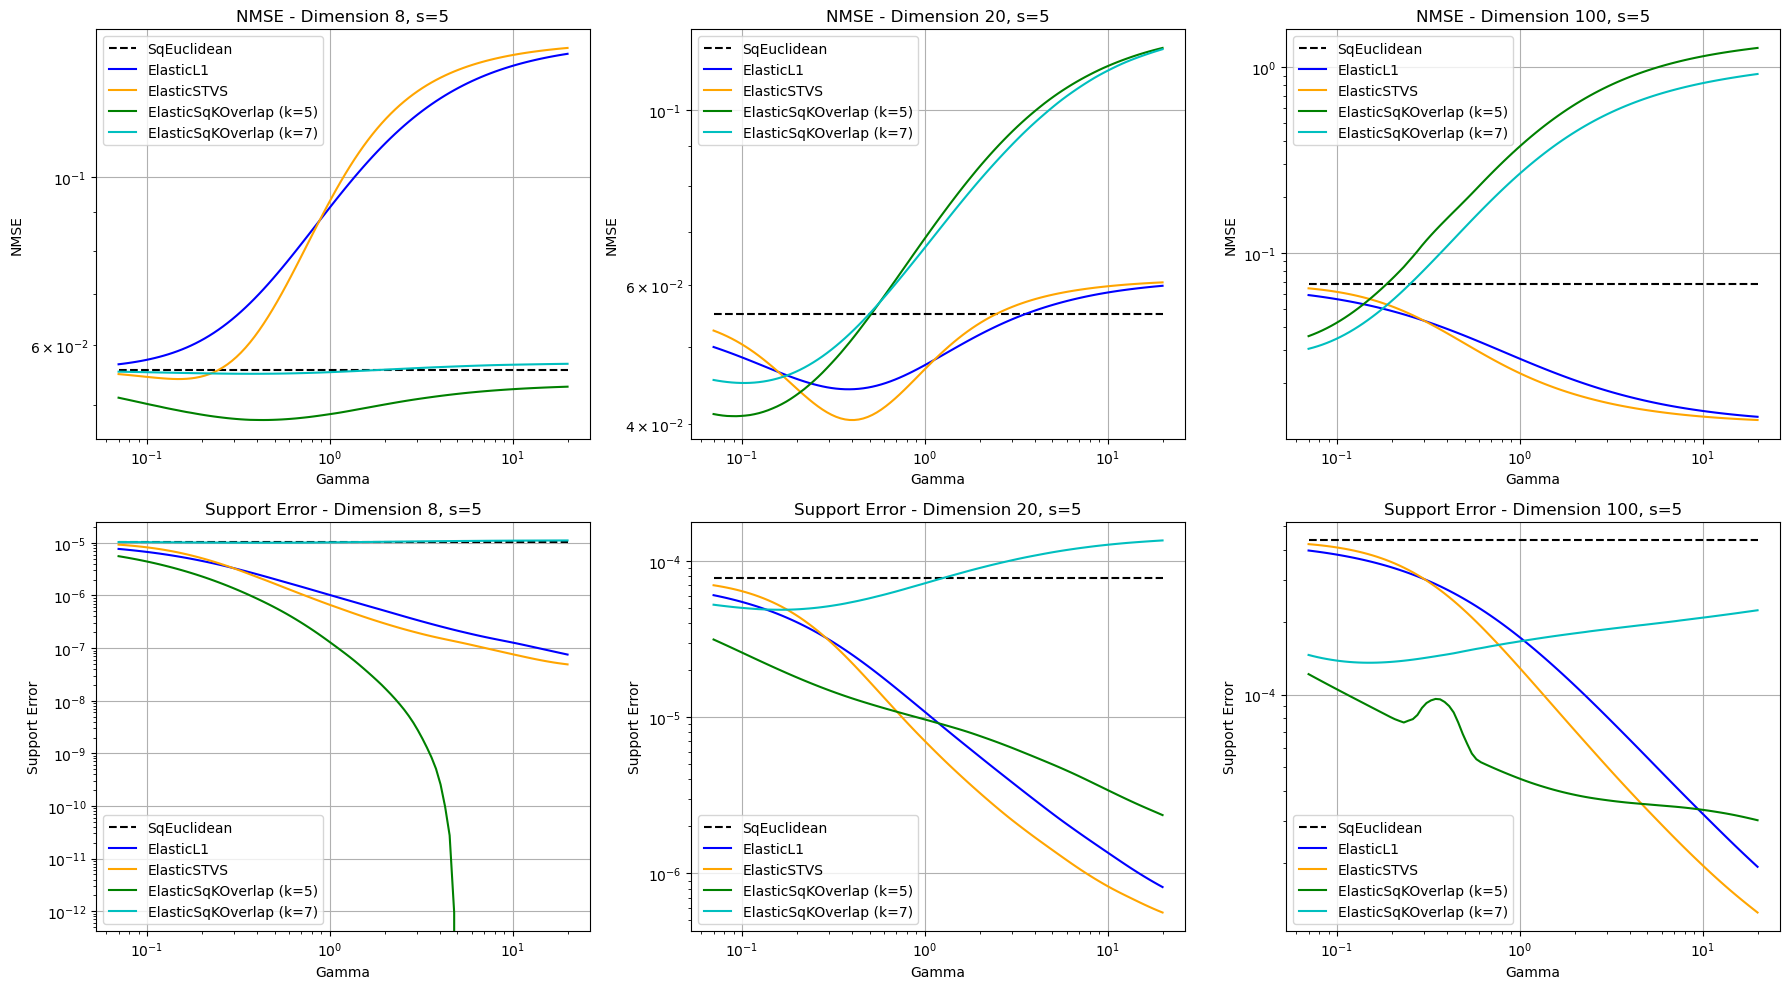

In [8]:
# Subplots creation
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Definitions of colours and linestyles in order to reproduce the plot of the paper
colors = ['k', 'b', 'orange', 'g', 'c']
linestyles = ['--', '-', '-', '-', '-']

for i, cost in enumerate(costs):
    for j, dimension in enumerate(dimensions):

        # Plot NMSE
        axs[0, j].plot(gammas, NMSE[cost][dimension][s], label=cost, color=colors[i], linestyle=linestyles[i])
        axs[0, j].set_title(f"NMSE - Dimension {dimension}, s={s}")
        axs[0, j].set_xlabel('Gamma')
        axs[0, j].set_ylabel('NMSE')
        axs[0, j].set_xscale('log')
        axs[0, j].set_yscale('log')
        axs[0, j].grid(True)
        axs[0, j].legend()

        # Plot Support Error
        axs[1, j].plot(gammas, SUPPORT_ERROR[cost][dimension][s], label=cost, color=colors[i], linestyle=linestyles[i])
        axs[1, j].set_title(f"Support Error - Dimension {dimension}, s={s}")
        axs[1, j].set_xlabel('Gamma')
        axs[1, j].set_ylabel('Support Error')
        axs[1, j].set_xscale('log')
        axs[1, j].set_yscale('log')
        axs[1, j].grid(True)
        axs[1, j].legend()

plt.tight_layout()
plt.show()


As you can see, we obtain the exact same results as those obtained in the paper.

In the first scenario (left size), where $d \approx s$, the $\ell_2^2$ cost performs adequately, and the proposed costs offer only marginal improvements in terms of NMSE. Nonetheless, our costs have a reduced Support Error associated.

Moving to the middle scenario, where the dimensionality d moderately exceeds the sparsity parameter s, all the proposed costs outperform the $\ell_2^2$ cost (with a right choice of the regularization parameter $\gamma$), and finite optimal regularization values emerge for $\ell_1$ and $\tau_{stvs}$ in terms of NMSE. When it comes to Support Error, all our costs (except the k-Overlap with $k = 7$) outperform the $\ell_2^2$ cost with an infinite optimal parameter.

In the third scenario (right size), where $d \gg s$, the proposed methods exhibit substantial improvements over the $\ell_2^2$ cost. For $\ell_1$ and $\tau_{stvs}$, the optimal regularization becomes infinite, even concerning NMSE. Furthermore, larger regularization consistently yields lower support error (except for the k-Overlap ($k = 7$)).

## x-dependent sparsity-pattern

We want to check if the method is able to recover transport maps whose sparsity pattern is adaptive. To do so, for each sample $x$, we compute $n_1 = \sum_{i=1}^{s} x_i^2$ and $n_2 = \sum_{i=s+1}^{2s} x_i^2$. $F_s(x) = \begin{cases}
[\exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d] &\text{if } n_1 > n_2  \\
[x_1, \ldots, x_s, \exp(x_{s+1}), \ldots, \exp(x_{2s}), x_{2s+1}, \ldots, x_d] &\text{otherwise}
\end{cases}$


We follow the reasoning of the experiment, modifying $T^*$ into $T^*_{alt}$.

In [9]:
def T_star_s_alt(x, s):
    n1 = jnp.sum(x[:s]**2).item()
    n2 = jnp.sum(x[s:2*s]**2).item()

    if n1 > n2:
        return jnp.concatenate([jnp.exp(x[:s]), x[s:]])
    else:
        return jnp.concatenate([x[:s], jnp.exp(x[s:2*s]), x[2*s:]])

We will now reproduce the experiment and check the results thanks to a plot.

In [10]:
# Setup to store all the NMSE's.
nmse = {}
dimensions = [7, 8, 9] + [i*10 for i in range(1, 10)] + [i*100 for i in range(1,11)]
gammas = jnp.logspace(jnp.log10(10**-5), jnp.log10(20), num=100) # Our grid will consider smaller regularization terms γ to get the lowest NMSE for the k-Overlap costs.
# For each elastic cost, we will store for each dimension d the test NMSE obtained by picking the γ that minimizes the test NMSE, after performing the grid search over gamma.
costs = ["SqEuclidean", "ElasticL1", "ElasticSTVS", "ElasticSqKOverlap (k=5)", "ElasticSqKOverlap (k=7)"]
for cost in costs:
    nmse[cost] = {}

# Define constants
n = 1000 # Number of samples
n_train = 100  # Number of training samples
s = 2  # Sparsity pattern size
# For each dimension, we store our synthetic data in a dictionary.
x_alt_diction = {}
y_alt_diction = {}
T_star_x_alt_diction = {}
for dimension in dimensions:
    x_alt_diction[dimension] = jax.random.uniform(rng, (n, dimension))
    x_tilde = jax.random.uniform(rng_tilde, (n, dimension))
    y_alt_diction[dimension] = jnp.array([T_star_s_alt(x, s) for x in x_tilde])
    T_star_x_alt_diction[dimension] = jnp.array([T_star_s_alt(x, s) for x in x_alt_diction[dimension]])

Again, we compute everything needed in the below single cell (make sure that your GPU/CPU has enough allocated memory in order to handle the computations for the biggest dimensions).

In [11]:
# # Run this cell if you get OOM errors trying to run the cell below. Feel free to check the JAX doc if that doesn't solve the problem : https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
# import os
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [12]:
# Loop over elastic costs and dimensions
for i, elastic_cost in enumerate([SqEuclidean, ElasticL1, ElasticSTVS, ElasticSqKOverlap, ElasticSqKOverlap]):
    for dimension in dimensions:
        x_alt = x_alt_diction[dimension]
        y_alt = y_alt_diction[dimension]
        T_star_x_alt = T_star_x_alt_diction[dimension]
        x_fold = x_alt[:n_train]
        x_test = x_alt[n_train:]
        y_fold = y_alt[:n_train]
        y_test = y_alt[n_train:]
        T_star_x_alt_fold = T_star_x_alt[:n_train]
        T_star_x_alt_test = T_star_x_alt[n_train:]
        if elastic_cost != SqEuclidean:
            # Perform grid search over γ on train fold
            best_gamma = None
            best_train_nmse = float('inf')
            for gamma in gammas:
                # Perform training with current gamma for each train fold
                # Run Sinkhorn algorithm to compute dual potentials
                if elastic_cost == ElasticSqKOverlap:
                    if i == 3:
                        cost = elastic_cost(k=5, scaling_reg=gamma)
                    else:
                        cost = elastic_cost(k=7, scaling_reg=gamma)
                else:
                    cost = elastic_cost(scaling_reg=gamma)

                # Compute NMSE and support error
                T_h_eps_train = compute_transport(x_fold, y_fold, cost)
                train_nmse = compute_nmse(T_star_x_alt_fold, T_h_eps_train)
                train_nmse = jnp.mean(jnp.sum((T_star_x_alt_fold - T_h_eps_train)**2, axis=1) / dimension)
                
                # Update best gamma if current NMSE is lower
                if train_nmse < best_train_nmse:
                    best_train_nmse = train_nmse
                    best_gamma = gamma
            
            if elastic_cost == ElasticSqKOverlap:
                if i == 3:
                    cost = elastic_cost(k=5, scaling_reg=best_gamma)
                else:
                    cost = elastic_cost(k=7, scaling_reg=best_gamma)
            else :
                cost = elastic_cost(scaling_reg=best_gamma)
        else:
            cost = SqEuclidean()

        # After finding the optimal γ, we compute the test NMSE and store it.
        T_h_eps_test = compute_transport(x_test, y_test, cost)
        test_nmse = compute_nmse(T_star_x_alt_test, T_h_eps_test)
        nmse[costs[i]][dimension] = test_nmse

Now, we check the results by plotting the same way it is done in the paper (Figure 6).

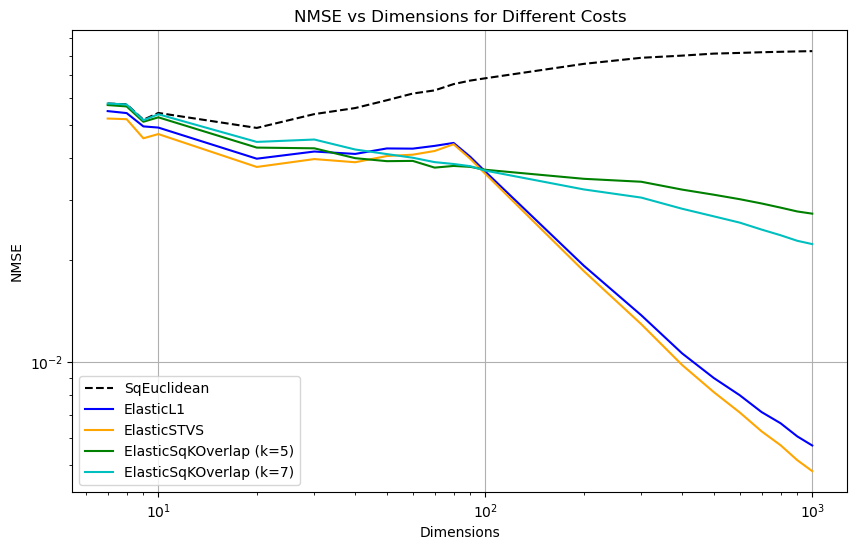

In [17]:
colors = ['k', 'b', 'orange', 'g', 'c']
linestyles = ['--', '-', '-', '-', '-']

plt.figure(figsize=(10, 6))
for i, cost in enumerate(costs):
    nmse_values = [nmse[cost][dimension] for dimension in dimensions]
    plt.plot(dimensions, nmse_values, label=cost, linestyle=linestyles[i], color=colors[i])

plt.xlabel('Dimensions')
plt.ylabel('NMSE')
plt.title('NMSE vs Dimensions for Different Costs')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

We get the same observation as the one is the paper : we notice that our costs scale much more efficiently compared to the standard $\ell_2^2$ cost, suggesting that our costs, promoting sparsity, help alleviate the curse of dimensionality.